In [1]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
from functools import partial
import torch
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

from src.data_cleaning import clean_tweet
from src.data_preprocessing import yield_tokens, collate_batch

In [2]:
# Set seed for reproducibility
seed = 2042
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Load data into pandas DataFrame
df = pd.read_csv("data/cyberbullying_tweets.csv")
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [5]:
# Get info about data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [6]:
# Rename feature and label columns
df = df.rename(columns={"tweet_text": "tweet", "cyberbullying_type": "category"})

# Remove duplicates
df = df[~df.duplicated()]

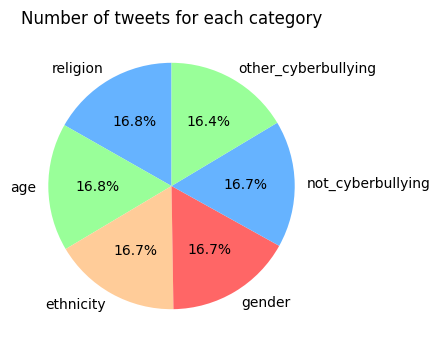

In [7]:
# Check distribution for cyberbullying category
category_counts = df["category"].value_counts()

# Create a pie chart
plt.figure(figsize=(4, 4))
plt.pie(category_counts, labels=category_counts.index, autopct="%1.1f%%", startangle=90, colors=["#66b3ff", "#99ff99", "#ffcc99", "#ff6666"])
plt.title("Number of tweets for each category")
plt.show()

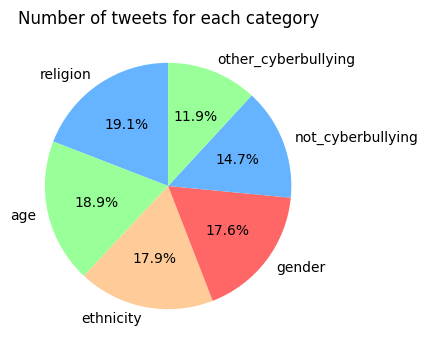

In [8]:
# Clean tweets using functions defined in src, and drop duplicates
# Define stop words for text cleaning
stop_words = set(stopwords.words("english"))
# Initialize lemmatizer for text cleaning
lemmatizer = WordNetLemmatizer()

df["clean_tweet"] = [clean_tweet(tweet, lemmatizer, stop_words) for tweet in df["tweet"]]
df.drop_duplicates("clean_tweet", inplace=True)

category_counts = df["category"].value_counts()

# Create a pie chart
plt.figure(figsize=(4, 4))
plt.pie(category_counts, labels=category_counts.index, autopct="%1.1f%%", startangle=90, colors=["#66b3ff", "#99ff99", "#ffcc99", "#ff6666"])
plt.title("Number of tweets for each category")
plt.show()

# After cleaning we can see that category "other_cyberbullying" is reduced to around 12%, because it is too generic
# Remove "other_cyberbullying category" due to its incosistency and being too generic
df = df[df["category"] != "other_cyberbullying"]

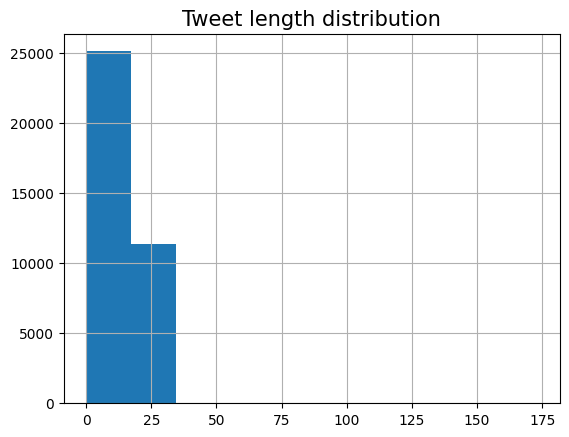

In [9]:
# Add columns for tweet length
df["tweet_length"] = [len(text.split()) for text in df.clean_tweet]
df.sort_values(by=["tweet_length"], ascending=False)

df["tweet_length"].hist()
plt.title("Tweet length distribution", size=15)
plt.show()

In [10]:
# Describe tweet length
print(df["tweet_length"].describe())

count    36499.000000
mean        14.264528
std          7.492135
min          0.000000
25%          8.000000
50%         12.000000
75%         20.000000
max        173.000000
Name: tweet_length, dtype: float64


In [11]:
# Removing outliers - tweets that are too long or too short
df = df[df["tweet_length"] < df["tweet_length"].quantile(0.995)]
df = df[df["tweet_length"] > 0]

In [12]:
# Map each category to numeric value
category_label_mapping = {
    "religion": 0,
    "age": 1,
    "gender": 2,
    "ethnicity": 3,
    "not_cyberbullying": 4
}

df["category"] = df["category"].map(category_label_mapping)

In [13]:
# Split data into Train and Test sets
X = df["clean_tweet"]
y = df["category"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed)

In [14]:
# We need to check if class/category distribution is balanced, if not, we should do oversampling
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5018],
       [   1, 4971],
       [   2, 4629],
       [   3, 4702],
       [   4, 3883]], dtype=int64)

In [15]:
# Add oversampling to training sets
rand_oversampler = RandomOverSampler()
X_train, y_train = rand_oversampler.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1))
train_os = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns = ["clean_tweet", "category"])

X_train = train_os["clean_tweet"].values
y_train = train_os["category"].values

# Check for counts again
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5018],
       [   1, 5018],
       [   2, 5018],
       [   3, 5018],
       [   4, 5018]], dtype=int64)

In [16]:
# Preprocess data and make it ready for model (tokeizing, creating vocabulary, torch dataloader)
train_iter = train_os

tokenizer = get_tokenizer("basic_english")
vocab = build_vocab_from_iterator(yield_tokens(train_iter, tokenizer, "clean_tweet"), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x)

dataloader = DataLoader(
    train_iter,
    batch_size=8,
    shuffle=False,
    collate_fn=partial(
        collate_batch,
        device=device,
        label_pipeline=label_pipeline,
        text_pipeline=text_pipeline,
        label_identiider="category",
        text_identifier="clean_tweet",
    ),
)
